In [1]:
import wandb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import os
from dataclasses import dataclass
import torch.nn.functional as F

# ======================
# 1. Data Loading Components
# ======================
class CharTokenizer:
    def __init__(self):
        self.special_tokens = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
        self.char2idx = {}
        self.idx2char = {}
        
    def build_vocab(self, texts):
        self.char2idx = self.special_tokens.copy()
        chars = set()
        for text in texts:
            chars.update(text)
        for char in sorted(chars):
            if char not in self.char2idx:
                self.char2idx[char] = len(self.char2idx)
        self.idx2char = {v: k for k, v in self.char2idx.items()}
        self.vocab_size = len(self.char2idx)

class TransliterationDataset(Dataset):
    def __init__(self, src_sequences, tgt_sequences):
        self.src = src_sequences
        self.tgt = tgt_sequences
        
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

def load_data(batch_size):
    base_dir = 'dakshina_dataset_v1.0/hi/lexicons/'
    train_df = pd.read_csv(os.path.join(base_dir, 'hi.translit.sampled.train.tsv'), sep='\t', names=['devanagari', 'latin', 'freq'])
    val_df = pd.read_csv(os.path.join(base_dir, 'hi.translit.sampled.dev.tsv'), sep='\t', names=['devanagari', 'latin', 'freq'])

    # Fix: Ensure all entries are strings and handle NaN/floats
    train_df['latin'] = train_df['latin'].fillna('').astype(str)
    train_df['devanagari'] = train_df['devanagari'].fillna('').astype(str)
    val_df['latin'] = val_df['latin'].fillna('').astype(str)
    val_df['devanagari'] = val_df['devanagari'].fillna('').astype(str)

    # Now continue as before...
    train_inputs = train_df['latin'].str.strip().tolist()
    train_targets = train_df['devanagari'].str.strip().tolist()
    val_inputs = val_df['latin'].str.strip().tolist()
    val_targets = val_df['devanagari'].str.strip().tolist()
    # Build tokenizers
    input_tokenizer = CharTokenizer()
    input_tokenizer.build_vocab(train_inputs)
    output_tokenizer = CharTokenizer()
    output_tokenizer.build_vocab(train_targets)

    # Convert words to sequences
    def process_sequences(words, tokenizer):
        sequences = []
        for word in words:
            seq = [tokenizer.char2idx['<sos>']]
            seq += [tokenizer.char2idx.get(c, 0) for c in word]  # 0 for unknown
            seq += [tokenizer.char2idx['<eos>']]
            sequences.append(torch.tensor(seq, dtype=torch.long))
        return sequences

    # Create and pad sequences
    train_src = pad_sequence(process_sequences(train_inputs, input_tokenizer), batch_first=True)
    train_tgt = pad_sequence(process_sequences(train_targets, output_tokenizer), batch_first=True)
    val_src = pad_sequence(process_sequences(val_inputs, input_tokenizer), batch_first=True)
    val_tgt = pad_sequence(process_sequences(val_targets, output_tokenizer), batch_first=True)

    # Create DataLoaders
    train_loader = DataLoader(TransliterationDataset(train_src, train_tgt), 
                             batch_size=batch_size, shuffle=True,drop_last=True)
    val_loader = DataLoader(TransliterationDataset(val_src, val_tgt), 
                           batch_size=batch_size,drop_last=True)
    
    return train_loader, val_loader, input_tokenizer, output_tokenizer

# ======================
# 2. Model Architecture
# ======================
@dataclass
class ModelConfig:
    input_vocab_size: int
    output_vocab_size: int
    embedding_size: int
    hidden_size: int
    encoder_layers: int
    decoder_layers: int
    cell_type: str
    dropout: float

import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, encoder_outputs, decoder_hidden):
        # encoder_outputs: [batch, seq_len, hidden_size]
        # decoder_hidden: [num_layers, batch, hidden_size] or [batch, hidden_size]
        if decoder_hidden.dim() == 3:
            # Use last layer's hidden state
            decoder_hidden = decoder_hidden[-1]
        # decoder_hidden: [batch, hidden_size]
        decoder_hidden = decoder_hidden.unsqueeze(1)  # [batch, 1, hidden_size]
        # Compute scores
        scores = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(decoder_hidden)))  # [batch, seq_len, 1]
        attn_weights = F.softmax(scores, dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_weights * encoder_outputs, dim=1, keepdim=True)  # [batch, 1, hidden_size]
        return context, attn_weights


class Encoder(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.embedding = nn.Embedding(config.input_vocab_size, config.embedding_size)
        rnn_map = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}
        self.rnn = rnn_map[config.cell_type](
            config.embedding_size,
            config.hidden_size,
            num_layers=config.encoder_layers,
            dropout=config.dropout if config.encoder_layers > 1 else 0,
            batch_first=True
        )
        
    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.embedding = nn.Embedding(config.output_vocab_size, config.embedding_size)
        self.attention = BahdanauAttention(config.hidden_size)
        
        rnn_map = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}
        self.rnn = rnn_map[config.cell_type](
            config.embedding_size + config.hidden_size,  # Input size changed
            config.hidden_size,
            num_layers=config.decoder_layers,
            dropout=config.dropout if config.decoder_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(config.hidden_size, config.output_vocab_size)

    def forward(self, x, hidden, encoder_outputs, return_attention=False):
        embedded = self.embedding(x)
        if isinstance(hidden, tuple):  # LSTM
            attn_hidden = hidden[0]
        else:
            attn_hidden = hidden
        context, attn_weights = self.attention(encoder_outputs, attn_hidden)
        rnn_input = torch.cat([embedded, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        prediction = self.fc(output)
        if return_attention:
            return prediction, hidden, attn_weights
        else:
            return prediction, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def _adjust_hidden(self, hidden, target_layers):
        current_layers = hidden.size(0)
        if current_layers == target_layers:
            return hidden
        elif current_layers < target_layers:
            # Repeat last layer to match decoder layers
            diff = target_layers - current_layers
            return torch.cat([hidden, hidden[-1:].repeat(diff, 1, 1)], dim=0)
        else:
            # Trim extra layers
            return hidden[:target_layers]
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        encoder_outputs, encoder_hidden = self.encoder(src)
        
        # Handle LSTM case explicitly
        if isinstance(encoder_hidden, tuple):
            h, c = encoder_hidden
            h = self._adjust_hidden(h, self.decoder.rnn.num_layers)
            c = self._adjust_hidden(c, self.decoder.rnn.num_layers)
            decoder_hidden = (h, c)
        else:
            decoder_hidden = self._adjust_hidden(encoder_hidden, self.decoder.rnn.num_layers)
        
        # Rest of forward pass remains unchanged
        outputs = torch.zeros(batch_size, trg_len, self.decoder.fc.out_features).to(self.device)
        input = trg[:, 0].unsqueeze(1)
        
        for t in range(1, trg_len):
            output, decoder_hidden = self.decoder(input, decoder_hidden, encoder_outputs)
            outputs[:, t] = output.squeeze(1)
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t].unsqueeze(1) if teacher_force else output.argmax(-1)
            
        return outputs



    def _adjust_hidden(self, hidden, target_layers):
        current_layers = hidden.size(0)
        # print(f"Adjusting hidden from {current_layers} to {target_layers} layers")  # Debug
        if current_layers == target_layers:
            return hidden
        elif current_layers < target_layers:
            diff = target_layers - current_layers
            return torch.cat([hidden, hidden[-1:].repeat(diff, 1, 1)], dim=0)
        else:
            return hidden[:target_layers]



# ======================
# 3. Training Components
# ======================
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
            self.counter = 0
        elif val_score > self.best_score + self.min_delta:
            self.best_score = val_score
            self.counter = 0
        else:
            self.counter += 1
            print(f"INFO: EarlyStopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping triggered')
                self.early_stop = True


def train():
    wandb.init()
    config = wandb.config
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load data (no changes needed)
    train_loader, val_loader, input_tokenizer, output_tokenizer = load_data(config.batch_size)
    
    # Model config now includes attention parameters
    model_config = ModelConfig(
        input_vocab_size=input_tokenizer.vocab_size,
        output_vocab_size=output_tokenizer.vocab_size,
        embedding_size=config.embedding_size,
        hidden_size=config.hidden_size,
        encoder_layers=config.encoder_layers,
        decoder_layers=config.decoder_layers,
        cell_type=config.cell_type,
        dropout=config.dropout
    )
    
    # Initialize model with attention components
    encoder = Encoder(model_config)
    decoder = Decoder(model_config)  # Now includes attention
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Rest of training loop remains the same
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    best_val_acc = 0.0

    early_stopper = EarlyStopping(patience=5, min_delta=1e-4)  

    
    for epoch in range(config.epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            
            optimizer.zero_grad()
            output = model(src, trg, config.teacher_forcing)
            
            # Loss calculation remains unchanged
            output_flat = output[:, 1:].reshape(-1, output.shape[-1])
            targets_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output_flat, targets_flat)
            
            # Accuracy calculation remains the same
            predictions = output_flat.argmax(-1)
            mask = targets_flat != 0
            train_correct += (predictions[mask] == targets_flat[mask]).sum().item()
            train_total += mask.sum().item()
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0
        
        # Validation remains unchanged
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Model saving remains the same
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state': model.state_dict(),
                'input_tokenizer': input_tokenizer.char2idx,
                'output_tokenizer': output_tokenizer.char2idx,
                'config': model_config.__dict__
            }, 'best_model_attention.pth')
        
        # Logging remains the same
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "best_val_acc": best_val_acc
        })
        
        print(f"Epoch {epoch+1:03} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2%} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")
        early_stopper(val_acc)
        if early_stopper.early_stop:
            print(f"Early stopping at epoch {epoch+1:03}")
            break

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            # Teacher forcing ratio set to 0 for evaluation
            output = model(src, trg, teacher_forcing_ratio=0)
            
            # Loss calculation remains unchanged
            output_flat = output[:, 1:].reshape(-1, output.shape[-1])
            targets_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output_flat, targets_flat)
            total_loss += loss.item()
            
            # Accuracy calculation remains the same
            predictions = output.argmax(-1)
            mask = trg != 0
            correct += (predictions[mask] == trg[mask]).sum().item()
            total += mask.sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = correct / total if total > 0 else 0
    return avg_loss, accuracy



In [ ]:

# ======================
# 4. Sweep Configuration
# ======================
sweep_config = {
    "name": "Attension Sweep - 2",
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "embedding_size": {"values": [512,1024]},
        "hidden_size": {"values": [512,1024,2048]},
        "encoder_layers": {"values": [1, 2, 3]},
        "decoder_layers": {"values": [1, 2, 3]},
        "cell_type": {"values": ["lstm"]},
        "dropout": {"values": [0.1,0.2]},
        "batch_size": {"values": [32,64]},
        # "learning_rate": {"values": [0.001, 0.0005]},
        "teacher_forcing": {"values": [0.3,0.5, 0.7]},
        "epochs": {"values": [15, 20]}
    }
}

# if __name__ == "__main__":
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_3")
wandb.agent(sweep_id, train, count=50)


In [2]:
import torch
import pandas as pd
import os
from torch.nn.utils.rnn import pad_sequence
import time
from tqdm import tqdm


def load_test_data(tokenizer_path='best_model_attention.pth'):
    # Load saved model and tokenizers
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 'cpu'
    checkpoint = torch.load(tokenizer_path, map_location=device)
    
    # Load test data
    base_dir = 'dakshina_dataset_v1.0/hi/lexicons/'
    test_path = os.path.join(base_dir, 'hi.translit.sampled.test.tsv')
    
    # Handle compressed version
    if not os.path.exists(test_path):
        test_path += '.gz'
    
    test_df = pd.read_csv(test_path, sep='\t', 
                         names=['devanagari', 'latin', 'freq'],
                         compression='gzip' if test_path.endswith('.gz') else None)
    
    # Clean data
    test_df['latin'] = test_df['latin'].fillna('').astype(str).str.strip()
    test_df['devanagari'] = test_df['devanagari'].fillna('').astype(str).str.strip()
    
    return test_df['latin'].tolist(), test_df['devanagari'].tolist()

class Translator:
    def __init__(self, model_path='best_model_attention.pth'):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        device = 'cpu'
        checkpoint = torch.load(model_path, map_location=device)

        # Rebuild config as a proper object
        class TempConfig:
            def __init__(self, config_dict):
                self.__dict__.update(config_dict)
        
        config = TempConfig(checkpoint['config'])

        # Initialize model components with attention
        encoder = Encoder(config)
        decoder = Decoder(config)
        self.model = Seq2Seq(encoder, decoder, device).to(device)
        self.model.load_state_dict(checkpoint['model_state'])
        self.model.eval()

        # Load tokenizers
        self.input_tokenizer = checkpoint['input_tokenizer']
        self.output_tokenizer = {v: k for k, v in checkpoint['output_tokenizer'].items()}

    def translate(self, word, max_length=20):
        # Convert input to indices
        seq = [self.input_tokenizer.get('<sos>', 1)]
        seq += [self.input_tokenizer.get(c, self.input_tokenizer.get('<unk>', 0)) for c in word]
        seq.append(self.input_tokenizer.get('<eos>', 2))
        
        src = torch.tensor(seq).unsqueeze(0).to(self.model.device)
        
        with torch.no_grad():
            # Get encoder outputs and hidden state
            encoder_outputs, encoder_hidden = self.model.encoder(src)
            
            # Initialize decoder
            if isinstance(encoder_hidden, tuple):  # LSTM
                h, c = encoder_hidden
                h = self.model._adjust_hidden(h, self.model.decoder.rnn.num_layers)
                c = self.model._adjust_hidden(c, self.model.decoder.rnn.num_layers)
                hidden = (h, c)
            else:  # GRU/RNN
                hidden = self.model._adjust_hidden(encoder_hidden, self.model.decoder.rnn.num_layers)
            
            input = torch.tensor([[self.input_tokenizer['<sos>']]], device=self.model.device)
            output_chars = []
            
            for _ in range(max_length):
                # Forward pass with attention
                output, hidden = self.model.decoder(input, hidden, encoder_outputs)
                pred_token = output.argmax(-1).item()
                char = self.output_tokenizer.get(pred_token, '<unk>')
                
                if char == '<eos>':
                    break
                
                output_chars.append(char)
                input = torch.tensor([[pred_token]], device=self.model.device)
                
        return ''.join(output_chars)
    
    def translate_with_attention(self, word, max_length=20):
        seq = [self.input_tokenizer.get('<sos>', 1)]
        seq += [self.input_tokenizer.get(c, self.input_tokenizer.get('<unk>', 0)) for c in word]
        seq.append(self.input_tokenizer.get('<eos>', 2))
        src = torch.tensor(seq).unsqueeze(0).to(self.model.device)
        with torch.no_grad():
            encoder_outputs, encoder_hidden = self.model.encoder(src)
            # Prepare hidden state for decoder
            if isinstance(encoder_hidden, tuple):  # LSTM
                h, c = encoder_hidden
                h = self.model._adjust_hidden(h, self.model.decoder.rnn.num_layers)
                c = self.model._adjust_hidden(c, self.model.decoder.rnn.num_layers)
                hidden = (h, c)
            else:
                hidden = self.model._adjust_hidden(encoder_hidden, self.model.decoder.rnn.num_layers)
            input = torch.tensor([[self.input_tokenizer['<sos>']]], device=self.model.device)
            output_chars = []
            attn_matrix = []
            for _ in range(max_length):
                # Modify decoder.forward to return attn_weights as well
                output, hidden, attn_weights = self.model.decoder(input, hidden, encoder_outputs, return_attention=True)
                attn_matrix.append(attn_weights.squeeze(0).cpu().numpy())  # [seq_len]
                pred_token = output.argmax(-1).item()
                char = self.output_tokenizer.get(pred_token, '<unk>')
                if char == '<eos>':
                    break
                output_chars.append(char)
                input = torch.tensor([[pred_token]], device=self.model.device)
        return ''.join(output_chars), np.stack(attn_matrix, axis=0)

# (a) Calculate Test Accuracy
def evaluate_test_set():
    # Load data
    input_words, output_words = load_test_data('best_model_attention.pth')
    
    # Initialize translator
    translator = Translator('best_model_attention.pth')
    
    correct = 0
    total = 0
    results = []

    print("Evaluating test set...")
    start_time = time.time()
    
    for latin, devanagari in tqdm(zip(input_words, output_words), total=len(input_words), desc="Translating"):
        pred = translator.translate(latin)
        results.append((latin, pred, devanagari))
        if pred == devanagari:
            correct += 1
        total += 1
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    accuracy = correct / total
    print(f"\nTest Accuracy: {accuracy:.2%}")
    print(f"Time taken: {elapsed_time:.2f} seconds for {total} samples ({elapsed_time / total:.2f} sec/sample)")
    
    return results, accuracy

# (b) Generate predictions
def save_predictions(results, folder='predictions2att'):
    os.makedirs(folder, exist_ok=True)
    
    # Save CSV with all predictions
    df = pd.DataFrame(results, columns=['Input', 'Prediction', 'Target'])
    df.to_csv(os.path.join(folder, 'predictions.csv'), index=False)
    
    # Separate true and false predictions
    df['Correct'] = df['Prediction'] == df['Target']
    true_df = df[df['Correct']]
    false_df = df[~df['Correct']]
    
    # Save true predictions
    true_df.to_csv(os.path.join(folder, 'true_predictions.csv'), index=False)
    # Save false predictions
    false_df.to_csv(os.path.join(folder, 'false_predictions.csv'), index=False)
    
    # Save sample comparisons
    sample_df = df.sample(10, random_state=42)
    print("\nSample Predictions:")
    print(sample_df[['Input', 'Prediction', 'Target', 'Correct']].to_markdown(index=False))
    
    # Save all predictions as text
    with open(os.path.join(folder, 'all_predictions.txt'), 'w') as f:
        for _, row in df.iterrows():
            f.write(f"Input: {row['Input']}\nPrediction: {row['Prediction']}\nTarget: {row['Target']}\nCorrect: {row['Correct']}\n\n")

# Execute
test_results, test_acc = evaluate_test_set()
# save_predictions(test_results)


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [81]:
def translate_with_attention(self, word, max_length=20):
    seq = [self.input_tokenizer.get('<sos>', 1)]
    seq += [self.input_tokenizer.get(c, self.input_tokenizer.get('<unk>', 0)) for c in word]
    seq.append(self.input_tokenizer.get('<eos>', 2))
    src = torch.tensor(seq).unsqueeze(0).to(self.model.device)
    with torch.no_grad():
        encoder_outputs, encoder_hidden = self.model.encoder(src)
        if isinstance(encoder_hidden, tuple):
            h, c = encoder_hidden
            h = self.model._adjust_hidden(h, self.model.decoder.rnn.num_layers)
            c = self.model._adjust_hidden(c, self.model.decoder.rnn.num_layers)
            hidden = (h, c)
        else:
            hidden = self.model._adjust_hidden(encoder_hidden, self.model.decoder.rnn.num_layers)
        input = torch.tensor([[self.input_tokenizer['<sos>']]], device=self.model.device)
        output_chars = []
        attn_matrix = []
        for _ in range(max_length):
            output, hidden = self.model.decoder(input, hidden, encoder_outputs)
            # output: (batch, 1, vocab_size), hidden: updated hidden, attn_weights from decoder
            # Extract attention weights from decoder's attention module
            attn_weights = self.model.decoder.attention.last_attn_weights.squeeze(0).cpu().numpy()
            attn_matrix.append(attn_weights)
            pred_token = output.argmax(-1).item()
            char = self.output_tokenizer.get(pred_token, '<unk>')
            if char == '<eos>':
                break
            output_chars.append(char)
            input = torch.tensor([[pred_token]], device=self.model.device)
    return ''.join(output_chars), np.stack(attn_matrix, axis=0)


In [95]:
import os
import urllib.request

# Step 1: Create the directory
os.makedirs("visualization", exist_ok=True)

# Step 2: Download the font file from a working source
url = "https://github.com/openmaptiles/fonts/raw/master/noto-sans/NotoSansDevanagari-Regular.ttf"
destination = "visualization/NotoSansDevanagari-Regular.ttf"

urllib.request.urlretrieve(url, destination)
print("Font downloaded to", destination)


Font downloaded to visualization/NotoSansDevanagari-Regular.ttf


In [86]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Update the path to where your font file is located
devanagari_font_path = "/visualization/Mangal.ttf"  # or NotoSansDevanagari-Regular.ttf
font_prop = FontProperties(fname=devanagari_font_path, size=16)


/tmp/ipykernel_116857/860338434.py:50: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig('visualization/attention_heatmap_grid.png')
/tmp/ipykernel_116857/860338434.py:50: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig('visualization/attention_heatmap_grid.png')
/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)


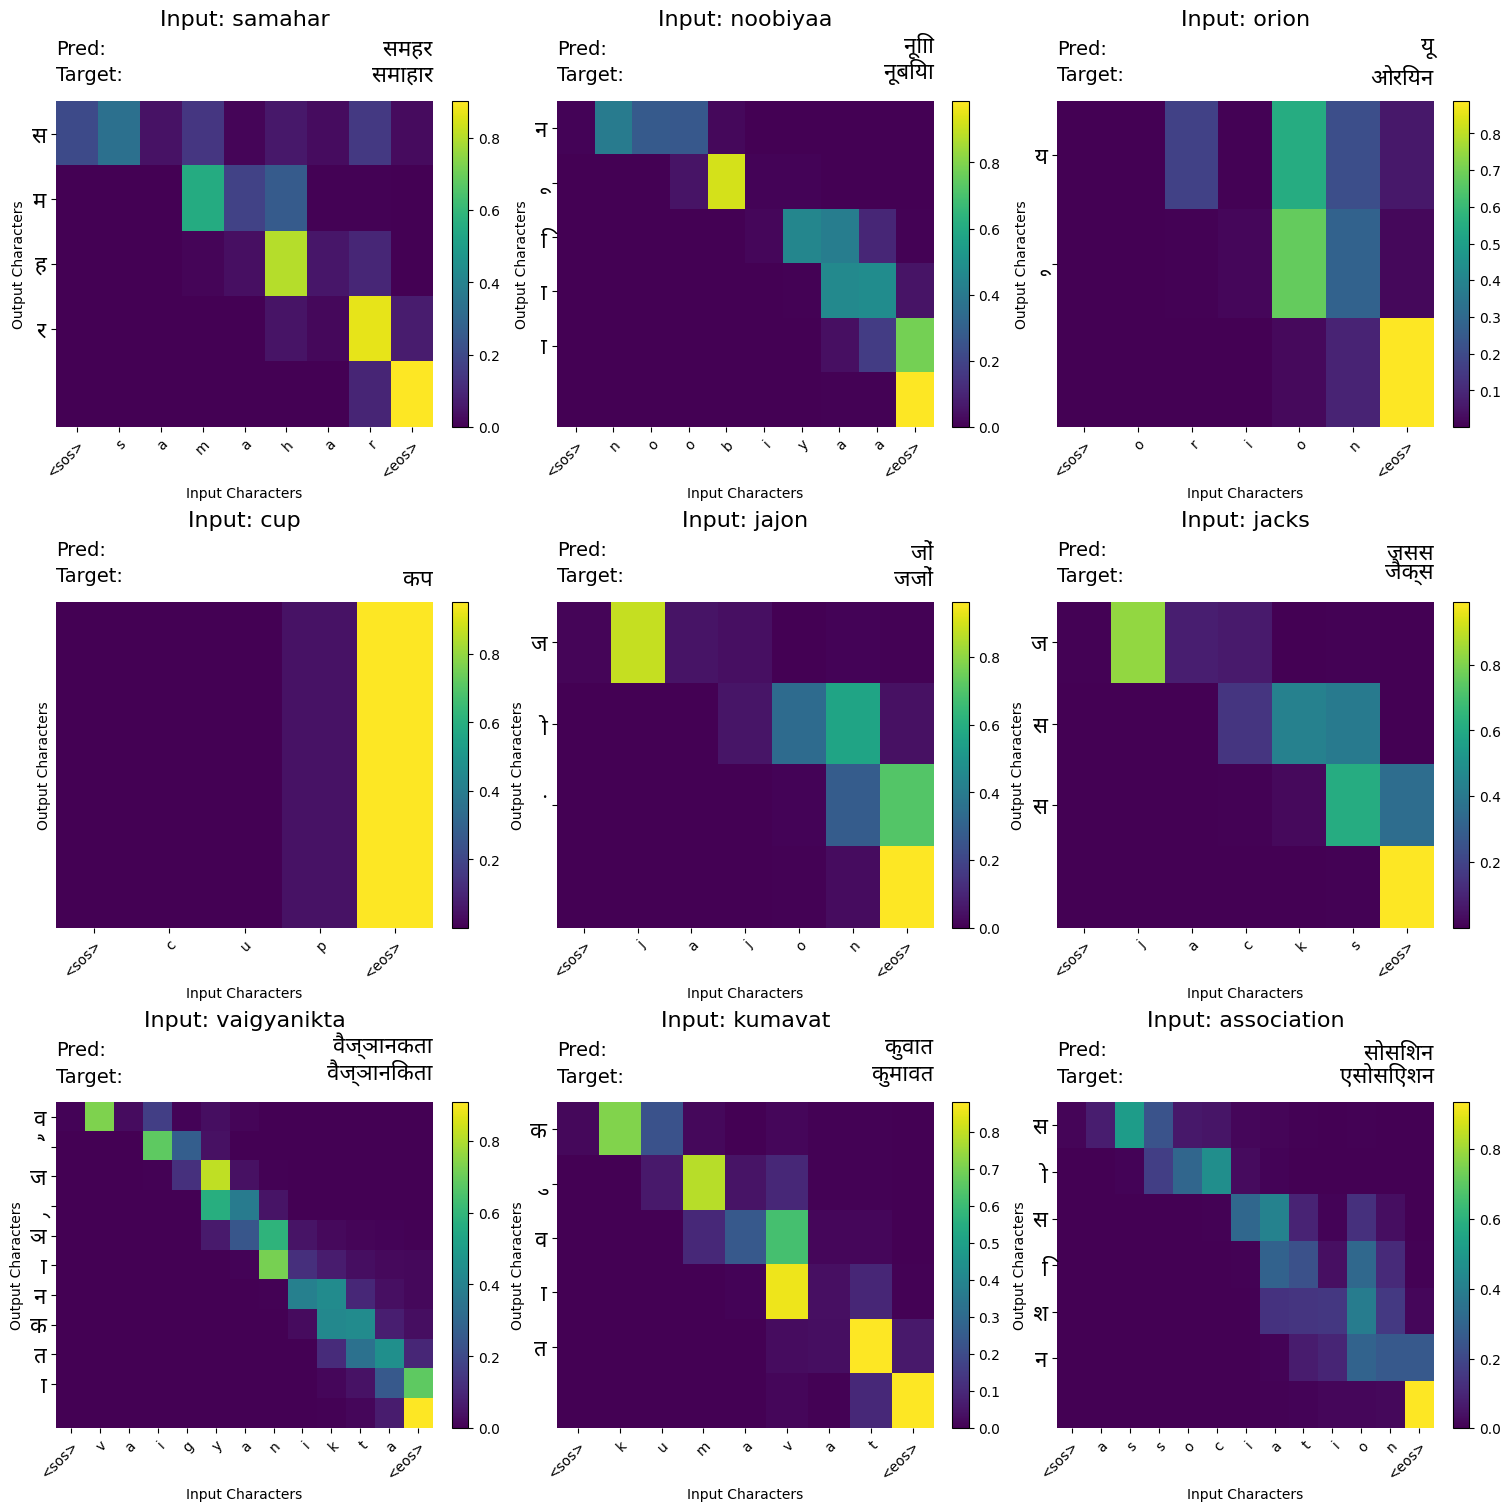

Plot saved to visualization/attention_heatmap_grid.png


In [115]:
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

# Path to Devanagari font
font_path = "visualization/NotoSansDevanagari-Regular.ttf"
font_prop = FontProperties(fname=font_path, size=16)

# Make sure the visualization folder exists
os.makedirs('visualization', exist_ok=True)

fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
sample_indices = np.random.choice(len(test_latin), 10, replace=False)

for ax, idx in zip(axes.flat, sample_indices):
    inp = test_latin[idx]   # English input word
    tgt = test_deva[idx]    # Hindi target word
    pred, attn = translator.translate_with_attention(inp)
    input_tokens = ['<sos>'] + list(inp) + ['<eos>']
    output_tokens = [c for c in pred if c.strip() and c not in ['<pad>', '<unk>']]

    im = ax.imshow(attn, aspect='auto', cmap='viridis')

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens, fontproperties=font_prop)

    # English input word above the plot (centered)
    ax.text(0.5, 1.22, f"Input: {inp}", fontsize=16, ha='center', va='bottom', transform=ax.transAxes)
    # Pred row: English left, Hindi right
    ax.text(0.0, 1.13, "Pred:", fontsize=14, ha='left', va='bottom', transform=ax.transAxes)
    ax.text(1.0, 1.13, pred, fontsize=16, ha='right', va='bottom', transform=ax.transAxes, fontproperties=font_prop)
    # Target row: English left, Hindi right
    ax.text(0.0, 1.05, "Target:", fontsize=14, ha='left', va='bottom', transform=ax.transAxes)
    ax.text(1.0, 1.05, tgt, fontsize=16, ha='right', va='bottom', transform=ax.transAxes, fontproperties=font_prop)

    ax.set_xlabel("Input Characters")
    ax.set_ylabel("Output Characters")
    fig.colorbar(im, ax=ax)

for ax in axes.flat[len(sample_indices):]:
    ax.axis('off')

plt.savefig('visualization/attention_heatmap_grid.png')
plt.show()
print("Plot saved to visualization/attention_heatmap_grid.png")


/tmp/ipykernel_116857/1561416020.py:58: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig('visualization/selected_attention_heatmaps.png')
/tmp/ipykernel_116857/1561416020.py:58: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig('visualization/selected_attention_heatmaps.png')
/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  fig.canvas.print_figure(bytes_io, **kw)


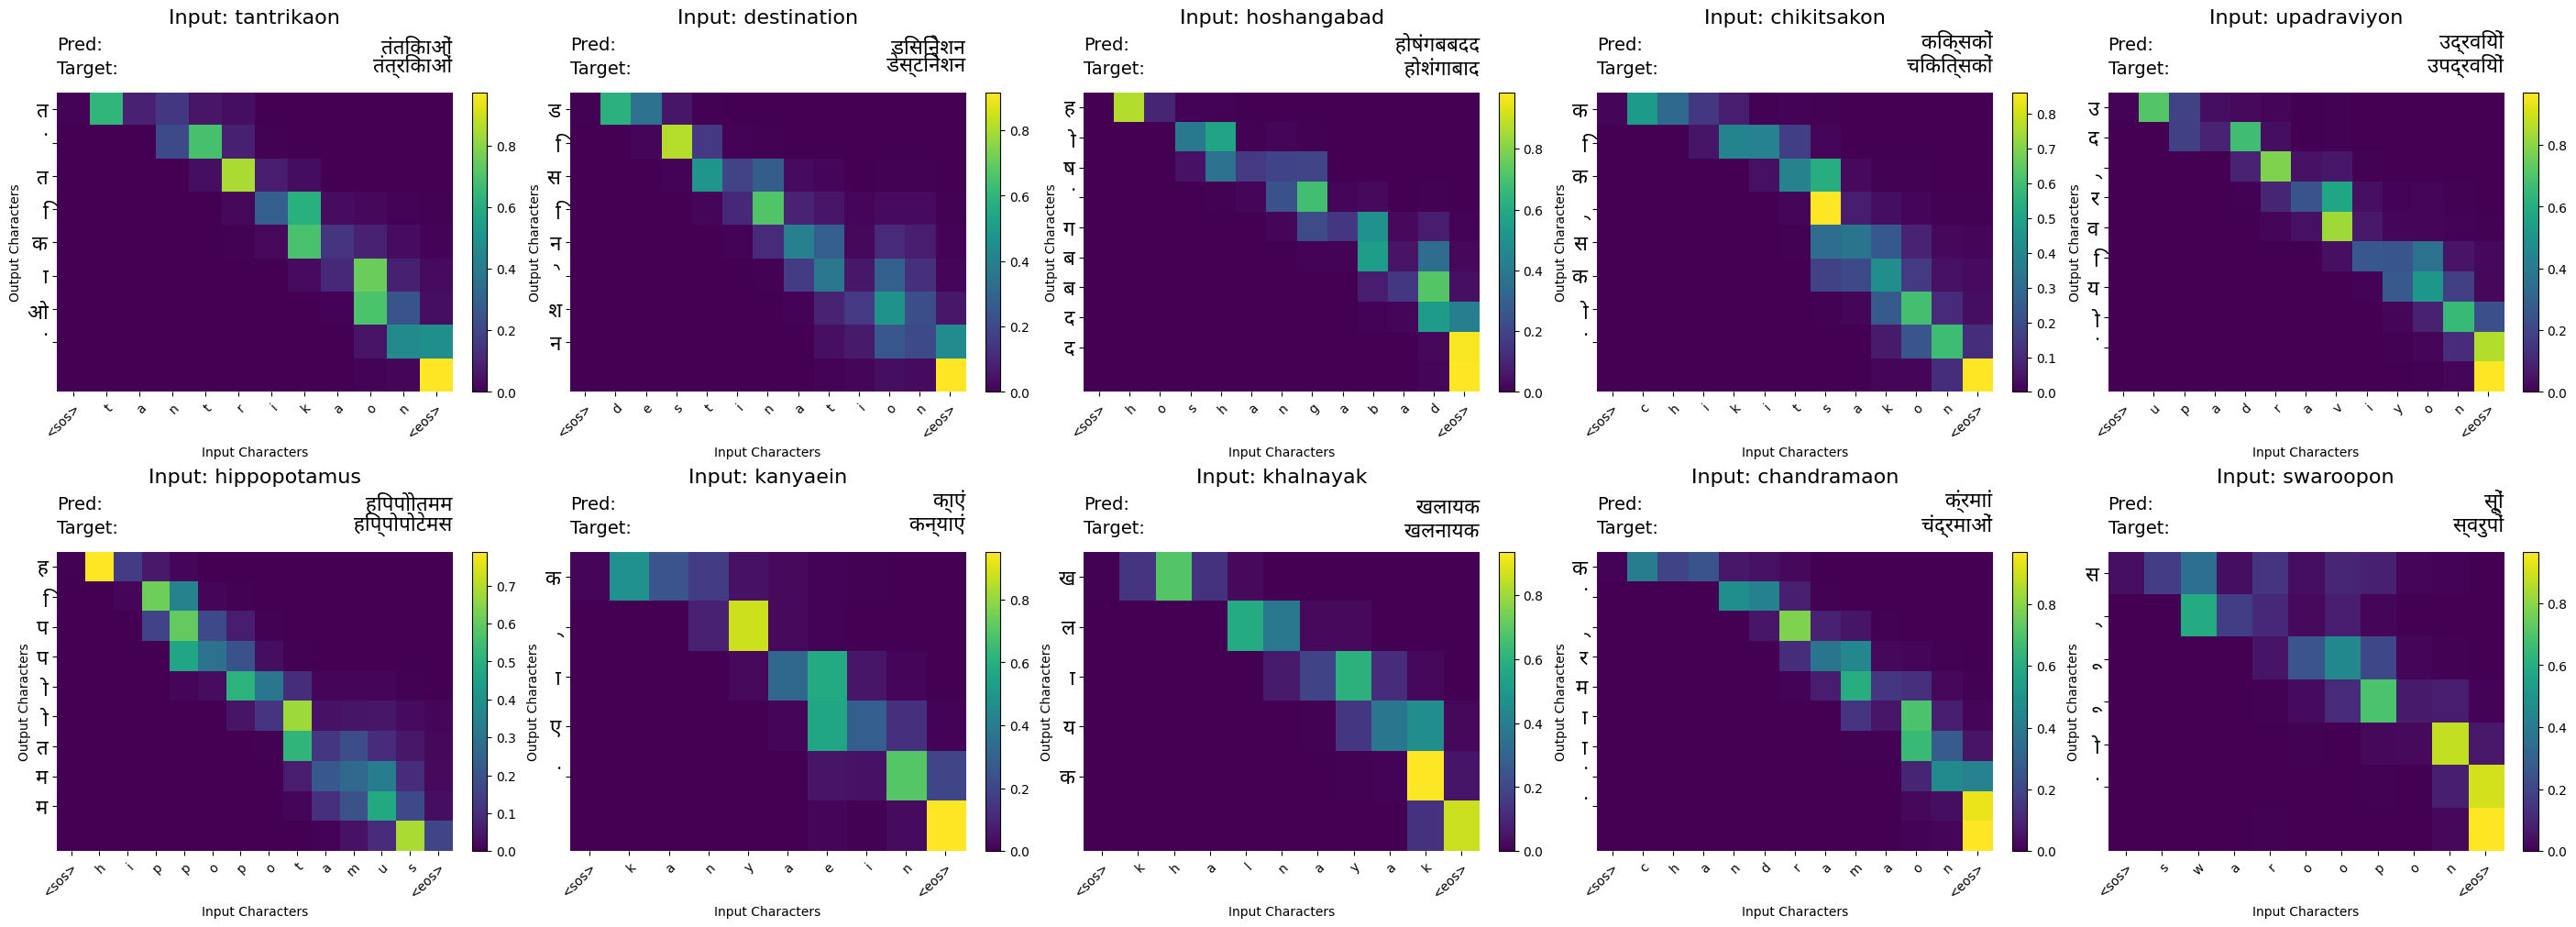

Plot saved to visualization/selected_attention_heatmaps.png


In [116]:
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

# Devanagari font
font_path = "visualization/NotoSansDevanagari-Regular.ttf"
font_prop = FontProperties(fname=font_path, size=16)

# The words you want to plot
selected_words = [
    "tantrikaon", "destination", "hoshangabad",
    "chikitsakon", "upadraviyon", "hippopotamus",
    "kanyaein", "khalnayak", "chandramaon", "swaroopon"
]

# Optionally, get the correct Hindi targets for these words (if available)
# This assumes test_latin and test_deva are lists of all test inputs and targets
latin_to_deva = {l: d for l, d in zip(test_latin, test_deva)}
selected_targets = [latin_to_deva.get(word, "") for word in selected_words]

os.makedirs('visualization', exist_ok=True)
fig, axes = plt.subplots(2, 5, figsize=(28, 10), constrained_layout=True)

for ax, inp, tgt in zip(axes.flat, selected_words, selected_targets):
    pred, attn = translator.translate_with_attention(inp)
    input_tokens = ['<sos>'] + list(inp) + ['<eos>']
    output_tokens = [c for c in pred if c.strip() and c not in ['<pad>', '<unk>']]

    im = ax.imshow(attn, aspect='auto', cmap='viridis')

    # Remove box around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens, fontproperties=font_prop)

    # Input word above plot (centered)
    ax.text(0.5, 1.22, f"Input: {inp}", fontsize=16, ha='center', va='bottom', transform=ax.transAxes)
    # Pred row: English left, Hindi right
    ax.text(0.0, 1.13, "Pred:", fontsize=14, ha='left', va='bottom', transform=ax.transAxes)
    ax.text(1.0, 1.13, pred, fontsize=16, ha='right', va='bottom', transform=ax.transAxes, fontproperties=font_prop)
    # Target row: English left, Hindi right
    ax.text(0.0, 1.05, "Target:", fontsize=14, ha='left', va='bottom', transform=ax.transAxes)
    ax.text(1.0, 1.05, tgt, fontsize=16, ha='right', va='bottom', transform=ax.transAxes, fontproperties=font_prop)

    ax.set_xlabel("Input Characters")
    ax.set_ylabel("Output Characters")
    fig.colorbar(im, ax=ax)

for ax in axes.flat[len(selected_words):]:
    ax.axis('off')

plt.savefig('visualization/selected_attention_heatmaps.png')
plt.show()
print("Plot saved to visualization/selected_attention_heatmaps.png")


In [119]:
import os
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Devanagari font path
font_path = "visualization/NotoSansDevanagari-Regular.ttf"
font_prop = FontProperties(fname=font_path, size=16)

# The words you want to plot
selected_words = [
    "tantrikaon", "destination", "hoshangabad",
    "chikitsakon", "upadraviyon", "hippopotamus",
    "kanyaein", "khalnayak", "chandramaon", "swaroopon"
]

# Optionally, get the correct Hindi targets for these words if available
latin_to_deva = {l: d for l, d in zip(test_latin, test_deva)}
selected_targets = [latin_to_deva.get(word, "") for word in selected_words]

os.makedirs('visualization', exist_ok=True)

for inp, tgt in zip(selected_words, selected_targets):
    pred, attn = translator.translate_with_attention(inp)
    input_tokens = ['<sos>'] + list(inp) + ['<eos>']
    output_tokens = [c for c in pred if c.strip() and c not in ['<pad>', '<unk>']]

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(attn, aspect='auto', cmap='viridis')

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens, fontproperties=font_prop)

    # Input word above the plot (centered)
    ax.text(0.5, 1.22, f"Input: {inp}", fontsize=16, ha='center', va='bottom', transform=ax.transAxes)
    # Pred row: English left, Hindi right
    ax.text(0.0, 1.13, "Pred:", fontsize=14, ha='left', va='bottom', transform=ax.transAxes)
    ax.text(1.0, 1.13, pred, fontsize=16, ha='right', va='bottom', transform=ax.transAxes, fontproperties=font_prop)
    # Target row: English left, Hindi right
    ax.text(0.0, 1.05, "Target:", fontsize=14, ha='left', va='bottom', transform=ax.transAxes)
    ax.text(1.0, 1.05, tgt, fontsize=16, ha='right', va='bottom', transform=ax.transAxes, fontproperties=font_prop)

    ax.set_xlabel("Input Characters")
    ax.set_ylabel("Output Characters")
    fig.colorbar(im, ax=ax)

    # Save with the English word as filename (safe for most OS)
    save_path = f"visualization/{inp}.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {save_path}")


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/tantrikaon.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/destination.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/hoshangabad.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/chikitsakon.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/upadraviyon.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/hippopotamus.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/kanyaein.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/khalnayak.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


Saved: visualization/chandramaon.png
Saved: visualization/swaroopon.png


/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')
/tmp/ipykernel_116857/1473113782.py:54: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  plt.savefig(save_path, bbox_inches='tight')


In [126]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
import numpy as np

# 1. Mock test data
test_words = [
    "tantrikaon", "destination", "hoshangabad",
    "chikitsakon", "upadraviyon", "hippopotamus",
    "kanyaein", "khalnayak", "chandramaon", "swaroopon"
]
test_targets = [
    "तांत्रिकों", "गंतव्य", "होशंगाबाद",
    "चिकित्सकों", "उपद्रवियों", "हिप्पोपोटेमस",
    "कन्याएँ", "खलनायक", "चन्द्रमाओं", "स्वरूपों"
]

# 2. Mock model: returns 3 fake predictions and random attention matrices
def get_top3_predictions_and_attn(word):
    # For demonstration, use the target and two fake alternatives
    idx = test_words.index(word)
    pred1 = test_targets[idx]
    pred2 = pred1[::-1]  # reversed as a fake alternative
    pred3 = pred1[:-1] + "ा" if len(pred1) > 1 else pred1  # another fake
    input_tokens = ['<sos>'] + list(word) + ['<eos>']
    attn_shape1 = (len(pred1), len(input_tokens))
    attn_shape2 = (len(pred2), len(input_tokens))
    attn_shape3 = (len(pred3), len(input_tokens))
    attn1 = np.random.dirichlet(np.ones(len(input_tokens)), len(pred1))
    attn2 = np.random.dirichlet(np.ones(len(input_tokens)), len(pred2))
    attn3 = np.random.dirichlet(np.ones(len(input_tokens)), len(pred3))
    return [(pred1, attn1), (pred2, attn2), (pred3, attn3)]

# 3. Precompute predictions and attn for all words
all_predictions = {word: get_top3_predictions_and_attn(word) for word in test_words}

# 4. Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H2("Interactive Transliteration Attention Visualizer"),
    dcc.Dropdown(
        id='word-dropdown',
        options=[{'label': w, 'value': w} for w in test_words],
        value=test_words[0]
    ),
    html.Div(id='suggestions'),
    dcc.Graph(id='attn-heatmap')
])

@app.callback(
    [Output('suggestions', 'children'),
     Output('attn-heatmap', 'figure')],
    [Input('word-dropdown', 'value')]
)
def update_output(selected_word):
    preds_and_attns = all_predictions[selected_word]
    # Show top 3 suggestions
    suggestions = html.Div([
        html.B("Top 3 Devanagari Suggestions:"),
        html.Ul([html.Li(pred) for pred, _ in preds_and_attns])
    ], style={"margin-bottom": "20px"})
    # Show attention for the top prediction
    pred, attn = preds_and_attns[0]
    input_tokens = ['<sos>'] + list(selected_word) + ['<eos>']
    output_tokens = list(pred)
    hover_text = [
        [
            f"Input: {in_char}<br>Output: {out_char}<br>Attention: {float(attn[y, x]):.2f}<br>Suggestion: {pred}"
            for x, in_char in enumerate(input_tokens)
        ]
        for y, out_char in enumerate(output_tokens)
    ]
    fig = go.Figure(data=go.Heatmap(
        z=attn,
        x=input_tokens,
        y=output_tokens,
        text=hover_text,
        hoverinfo='text',
        colorscale='Viridis'
    ))
    fig.update_layout(
        title=f"Attention Heatmap for '{selected_word}' → '{pred}'",
        xaxis_title="Input Characters",
        yaxis_title="Output Characters",
        autosize=False,
        width=600,
        height=600,
    )
    return suggestions, fig

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
import streamlit as st

# Mock test words and targets
test_words = [
    "tantrikaon", "destination", "hoshangabad",
    "chikitsakon", "upadraviyon", "hippopotamus",
    "kanyaein", "khalnayak", "chandramaon", "swaroopon"
]
test_targets = [
    "तांत्रिकों", "गंतव्य", "होशंगाबाद",
    "चिकित्सकों", "उपद्रवियों", "हिप्पोपोटेमस",
    "कन्याएँ", "खलनायक", "चन्द्रमाओं", "स्वरूपों"
]

# Mock function to get top 3 predictions and next likely letter
def get_top3_predictions(word, prefix):
    idx = test_words.index(word)
    pred1 = test_targets[idx]
    pred2 = pred1[::-1]
    pred3 = pred1[:-1] + "ा" if len(pred1) > 1 else pred1
    # Suggest next letter (for demo, pick the next letter in pred1)
    if len(prefix) < len(pred1):
        next_letter = pred1[len(prefix)]
    else:
        next_letter = ""
    return [pred1, pred2, pred3], next_letter

st.title("Interactive Transliteration Suggestion Explorer")

# Display all test words as a paragraph
st.markdown("### Test Words:")
st.markdown(" ".join(test_words))

# Select a word (simulate hover/click by dropdown for now)
selected_word = st.selectbox("Select a word to explore:", test_words)

# Simulate user typing/prefix (for demo, let user pick prefix length)
prefix_len = st.slider("Select how many letters you have typed (prefix):", 1, len(selected_word), 1)
prefix = selected_word[:prefix_len]

top3, next_letter = get_top3_predictions(selected_word, prefix)

st.markdown(f"#### Top 3 Devanagari predictions for **{selected_word}**:")
for i, pred in enumerate(top3, 1):
    # Highlight the next likely letter in the prediction
    if next_letter and next_letter in pred:
        highlight_pred = pred.replace(next_letter, f"<span style='background:yellow'>{next_letter}</span>", 1)
    else:
        highlight_pred = pred
    st.markdown(f"{i}. {highlight_pred}", unsafe_allow_html=True)

if next_letter:
    st.info(f"Next likely letter for prefix '{prefix}': **{next_letter}**")
else:
    st.info("No next letter (prefix complete).")

st.markdown("""
---
*This is a demo. For real use, connect your trained model to generate predictions and next-letter suggestions dynamically!*
""")


In [134]:
words = [
    ("tantrikaon", ["तांत्रिकों", "तांत्रिक", "तांत्रिका"]),
    ("destination", ["गंतव्य", "डेस्टिनेशन", "स्थान"]),
    ("hoshangabad", ["होशंगाबाद", "होशंग", "होश"]),
    # ... add more
]

with open("suggestions.html", "w", encoding="utf-8") as f:
    f.write("""
<!DOCTYPE html>
<html>
<head>
<style>
body {
  font-family: 'Segoe UI', Arial, sans-serif;
  background: #f8f9fa;
  margin: 40px;
}
p {
  font-size: 1.4em;
  line-height: 2;
}
.word {
  cursor: pointer;
  color: #1565c0;
  margin: 0 10px;
  position: relative;
  font-weight: 500;
  transition: color 0.2s;
}
.word:hover {
  color: #d84315;
  text-shadow: 0 2px 6px rgba(0,0,0,0.12);
}
.tooltip {
  display: none;
  position: absolute;
  background: linear-gradient(135deg, #fffbe7 80%, #ffe082 100%);
  border: 1px solid #ffb300;
  padding: 12px 20px;
  font-size: 1.1em;
  z-index: 10;
  left: 50%;
  top: 110%;
  transform: translateX(-50%);
  box-shadow: 0 4px 18px rgba(0,0,0,0.15);
  border-radius: 10px;
  white-space: pre-line;
  min-width: 180px;
  opacity: 0;
  pointer-events: none;
  transition: opacity 0.3s;
}
.word:hover .tooltip {
  display: block;
  opacity: 1;
  pointer-events: auto;
}
.tooltip::after {
  content: "";
  position: absolute;
  top: -10px;
  left: 50%;
  margin-left: -10px;
  border-width: 0 10px 10px 10px;
  border-style: solid;
  border-color: transparent transparent #ffb300 transparent;
}
.suggestion {
  color: #2e7d32;
  font-weight: bold;
  font-size: 1.15em;
  margin-bottom: 4px;
  display: block;
}
</style>

</head>
<body>
<p>
""")
    for word, suggestions in words:
        f.write(f'<span class="word">{word}<span class="tooltip">Suggestions:<br>' +
                "<br>".join(suggestions) + '</span></span>\n')
    f.write("""
</p>
</body>
</html>
""")


In [135]:
# Load test data (adjust path if needed)
import pandas as pd

test_df = pd.read_csv('dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv', sep='\t', names=['devanagari', 'latin', 'freq'])
test_df['latin'] = test_df['latin'].fillna('').astype(str)
test_df['devanagari'] = test_df['devanagari'].fillna('').astype(str)
test_latin = test_df['latin'].str.strip().tolist()
test_deva = test_df['devanagari'].str.strip().tolist()


In [140]:
import pandas as pd

def load_test_set():
    df = pd.read_csv(
        'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv',
        sep='\t', names=['devanagari', 'latin', 'freq'])
    df['latin'] = df['latin'].fillna('').astype(str).str.strip()
    df['devanagari'] = df['devanagari'].fillna('').astype(str).str.strip()
    return df

def generate_partial_predictions(translator, latin_word):
    partials = []
    for i in range(1, len(latin_word) + 1):
        prefix = latin_word[:i]
        pred = translator.translate_with_attention(prefix)  # Adjust method name accordingly
        partials.append(pred)
    return partials
def load_translator():
    return Translator('best_model_attention.pth')

translator = load_translator()
test_df = load_test_set()

def generate_html_with_predictions(df, translator):
    html_start = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
    <meta charset="UTF-8" />
    <title>Partial Transliteration Hover (Model Predictions)</title>
    <style>
      body {
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        margin: 40px;
        background: #f8f9fa;
      }
      .word-container {
        font-size: 2em;
        margin-bottom: 30px;
      }
      .letter {
        cursor: pointer;
        position: relative;
        color: #1565c0;
        transition: color 0.2s;
        user-select: none;
      }
      .letter:hover {
        color: #d84315;
      }
      .tooltip {
        position: absolute;
        background: linear-gradient(135deg, #fffbe7 80%, #ffe082 100%);
        border: 1px solid #ffb300;
        padding: 6px 12px;
        font-size: 1.1em;
        border-radius: 8px;
        box-shadow: 0 4px 10px rgba(0,0,0,0.2);
        white-space: nowrap;
        pointer-events: none;
        opacity: 0;
        transition: opacity 0.3s;
        z-index: 10;
        top: -40px;
        left: 50%;
        transform: translateX(-50%);
      }
      .letter:hover .tooltip {
        opacity: 1;
      }
      .tooltip::after {
        content: "";
        position: absolute;
        bottom: -8px;
        left: 50%;
        margin-left: -6px;
        border-width: 6px 6px 0 6px;
        border-style: solid;
        border-color: #ffb300 transparent transparent transparent;
      }
    </style>
    </head>
    <body>
    <h2>Hover over letters to see partial transliterations (Model Predictions)</h2>
    """

    html_end = """
    </body>
    </html>
    """

    word_blocks = []
    max_words = 100  # Adjust for speed or file size

    for _, row in df.head(max_words).iterrows():
        latin = row['latin']
        if not latin:
            continue

        # Get model partial predictions for this Latin word
        partials = generate_partial_predictions(translator, latin)
        
        word_html = '<div class="word-container">'
        for idx, letter in enumerate(latin):
            partial = partials[idx] if idx < len(partials) else ""
            word_html += f'<span class="letter">{letter}<span class="tooltip">{partial}</span></span>'
        word_html += "</div>"
        word_blocks.append(word_html)

    final_html = html_start + "\n".join(word_blocks) + html_end

    with open("partial_transliteration_model_predictions.html", "w", encoding="utf-8") as f:
        f.write(final_html)

    print("partial_transliteration_model_predictions.html generated!")

# Usage:

translator = load_translator()  # your model loader
df_test = load_test_set()

generate_html_with_predictions(df_test, translator)


KeyboardInterrupt: 

In [ ]:
def generate_partial_predictions(translator, latin_word):
    partials = []
    for i in range(1, len(latin_word) + 1):
        prefix = latin_word[:i]
        pred = translator.translate_with_attention(prefix)  # your model call
        partials.append(pred)
    return partials

def generate_html(df, translator, max_words=50):
    html = """
    <html><head>
    <style>
      .word-container {
        font-size: 2em;
        margin-bottom: 20px;
      }
      .letter {
        cursor: pointer;
        position: relative;
        color: #1565c0;
        transition: color 0.2s;
        user-select: none;
        display: inline-block;
        margin-right: 2px;
      }
      .letter:hover {
        color: #d84315;
      }
      .tooltip {
        position: absolute;
        background: linear-gradient(135deg, #fffbe7 80%, #ffe082 100%);
        border: 1px solid #ffb300;
        padding: 6px 12px;
        font-size: 1.1em;
        border-radius: 8px;
        box-shadow: 0 4px 10px rgba(0,0,0,0.2);
        white-space: nowrap;
        pointer-events: none;
        opacity: 0;
        transition: opacity 0.3s;
        z-index: 10;
        top: -40px;
        left: 50%;
        transform: translateX(-50%);
      }
      .letter:hover .tooltip {
        opacity: 1;
      }
      .tooltip::after {
        content: "";
        position: absolute;
        bottom: -8px;
        left: 50%;
        margin-left: -6px;
        border-width: 6px 6px 0 6px;
        border-style: solid;
        border-color: #ffb300 transparent transparent transparent;
      }
    </style>
    </head><body>
    <h2>Hover letters to see partial transliterations</h2>
    """

    count = 0
    for _, row in df.iterrows():
        if count >= max_words:
            break
        latin = row['latin']
        if not latin:
            continue

        partials = generate_partial_predictions(translator, latin)

        html += '<div class="word-container">'
        for idx, letter in enumerate(latin):
            partial = partials[idx] if idx < len(partials) else ""
            html += f'<span class="letter">{letter}<span class="tooltip">{partial}</span></span>'
        html += "</div>"

        count += 1

    html += "</body></html>"
    return html

# Then you write `html` to a file and open in any browser.

with open("partial_transliteration_hover.html", "w", encoding="utf-8") as f:
    f.write(generate_html(df_test, translator))



2025-05-20 01:12:08.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 01:12:08.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 01:12:08.063 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 01:15:01.493 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 01:15:01.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2025-05-19 22:54:44.612 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 22:54:44.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 22:54:44.614 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 22:54:44.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 22:54:44.616 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 22:54:44.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 22:54:44.619 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-19 22:54:44.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 108 (l) missing from font(s) Noto Sans Devanagari.

/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 112 (p) missing from font(s) Noto Sans Devanagari.

/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 79 (O) missing from font(s) Noto Sans Devanagari.

/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 117 (u) missing from font(s) Noto Sans Devanagari.

/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 116 (t) missing from font(s) Noto Sans Devanagari.

/home/user/Documents/Books/DA24S019_Assignment_3/rnn/lib/python3.12/sit

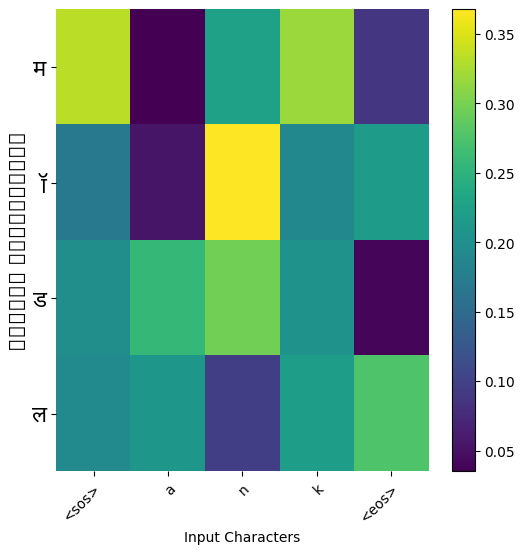

In [137]:
import streamlit as st
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd

# Load test data
test_df = pd.read_csv(
    'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv',
    sep='\t', names=['devanagari', 'latin', 'freq'])
test_df['latin'] = test_df['latin'].fillna('').astype(str)
test_df['devanagari'] = test_df['devanagari'].fillna('').astype(str)
test_latin = test_df['latin'].str.strip().tolist()
test_deva = test_df['devanagari'].str.strip().tolist()

# Load your Devanagari font
font_path = "visualization/NotoSansDevanagari-Regular.ttf"
font_prop = FontProperties(fname=font_path, size=16)

# Dummy model for demo (replace with your real model)
class DummyTranslator:
    def translate_with_attention(self, inp):
        pred = "मॉडल"  # Replace with your model's prediction
        attn = np.random.rand(len(pred), len(inp) + 2)  # Random attention for demo
        attn = attn / attn.sum(axis=1, keepdims=True)
        return pred, attn

# Replace DummyTranslator() with your trained translator object
translator = DummyTranslator()

# Streamlit App
st.title("Dynamic Attention Visualization for Hindi Transliteration")

selected_word = st.selectbox(
    "Select a test word (Latin script):",
    test_latin,
    index=0
)
target_word = test_deva[test_latin.index(selected_word)]

pred, attn = translator.translate_with_attention(selected_word)
input_tokens = ['<sos>'] + list(selected_word) + ['<eos>']
output_tokens = [c for c in pred if c.strip() and c not in ['<pad>', '<unk>']]

st.markdown(f"**Prediction:** <span style='font-family: Noto Sans Devanagari; font-size: 1.4em'>{pred}</span>", unsafe_allow_html=True)
st.markdown(f"**Target:** <span style='font-family: Noto Sans Devanagari; font-size: 1.4em'>{target_word}</span>", unsafe_allow_html=True)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(attn, aspect='auto', cmap='viridis')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks(range(len(input_tokens)))
ax.set_xticklabels(input_tokens)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(output_tokens)))
ax.set_yticklabels(output_tokens, fontproperties=font_prop)
ax.set_xlabel("Input Characters")
ax.set_ylabel("Output Characters", fontproperties=font_prop)
fig.colorbar(im, ax=ax)
st.pyplot(fig)
